In [1]:
import os
os.chdir('../')
from data.load_dataset import SoilSpectralDataSet
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from net.base_net import CuiNet , DeepSpectraCNN, ResNet18_1D , ViT_1D, FullyConvNet
from utils.training import train
from utils.testing import test
from utils.misc import data_augmentation


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    num_epochs = 1000
    BATCH = 2048
    LR = 0.00001
    save_interval = 50  # Save model every 10 epochs

In [3]:
y_labels = ["oc_usda.c729_w.pct", "na.ext_usda.a726_cmolc.kg"]  #,"clay.tot_usda.a334_w.pct", "k.ext_usda.a725_cmolc.kg", "ph.h2o_usda.a268_index"
                
dataset_type = "mir"
data_path ="C:\\00_aioly\\GitHub\datasets\\ossl\\ossl_all_L1_v1.2.csv"



In [4]:
augmentation = data_augmentation(slope = 0.1, offset = 0.1, noise = 0.1, shift = 0.1)
spectral_data = SoilSpectralDataSet(data_path=data_path, dataset_type=dataset_type, y_labels=y_labels, preprocessing=None)
spec_dims = spectral_data.spec_dims
dataset_size = len(spectral_data)

test_size = int(0.2 * dataset_size)  
train_val_size = dataset_size - test_size
train_size = int(0.75 * train_val_size)  
val_size = train_val_size - train_size

train_val_dataset, test_dataset = random_split(spectral_data, [train_val_size, test_size], generator=torch.Generator().manual_seed(seed))
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)


In [5]:
mean = np.zeros(spec_dims) 
std = np.zeros(spec_dims)

for inputs, targets in train_loader:
    mean += np.sum(np.array(inputs),axis = 0)                          
mean /= len(train_loader.dataset)

for inputs, targets in train_loader:
    
    std += np.sum((np.array(inputs)-mean)**2,axis = 0)        
std /= len(train_loader.dataset)

In [6]:
name_model ="_CuiNet_OSSL_"  
save_path = os.path.dirname(data_path) + f'\\models\\{name_model}\\'+ name_model

model = CuiNet(spec_dims, mean = mean,std = std, out_dims=len(y_labels)) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')

In [7]:
train_losses, val_losses, val_r2_scores , final_save_path=train(model, optimizer, criterion, train_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,plot_fig=False)

Epoch 1/1000 | Train Losses: y 0: 3876.7383, y 1: 3206.2715 | Validation Losses: y 0: 2191.6013, y 1: 2337.0596 | R2 Scores: y 0: -0.2565, y 1: -0.2475
Epoch 2/1000 | Train Losses: y 0: 3186.6443, y 1: 2740.0024 | Validation Losses: y 0: 1797.9669, y 1: 1992.7522 | R2 Scores: y 0: -0.2341, y 1: -0.2080
Epoch 3/1000 | Train Losses: y 0: 2653.6294, y 1: 2371.1692 | Validation Losses: y 0: 1526.0353, y 1: 1746.3424 | R2 Scores: y 0: -0.2104, y 1: -0.1713
Epoch 4/1000 | Train Losses: y 0: 2371.0461, y 1: 2174.6855 | Validation Losses: y 0: 1337.0468, y 1: 1566.2141 | R2 Scores: y 0: -0.1877, y 1: -0.1387
Epoch 5/1000 | Train Losses: y 0: 2078.3245, y 1: 1971.5818 | Validation Losses: y 0: 1202.9978, y 1: 1436.9819 | R2 Scores: y 0: -0.1681, y 1: -0.1121
Epoch 6/1000 | Train Losses: y 0: 1847.9705, y 1: 1863.3785 | Validation Losses: y 0: 1101.0735, y 1: 1339.8478 | R2 Scores: y 0: -0.1503, y 1: -0.0911
Epoch 7/1000 | Train Losses: y 0: 1732.3337, y 1: 1776.4685 | Validation Losses: y 0: 10

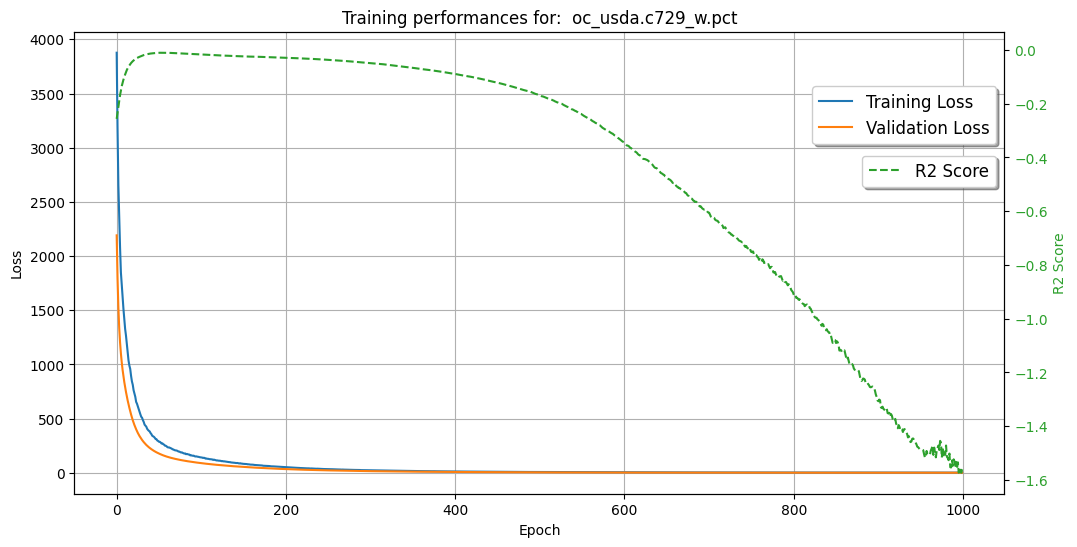

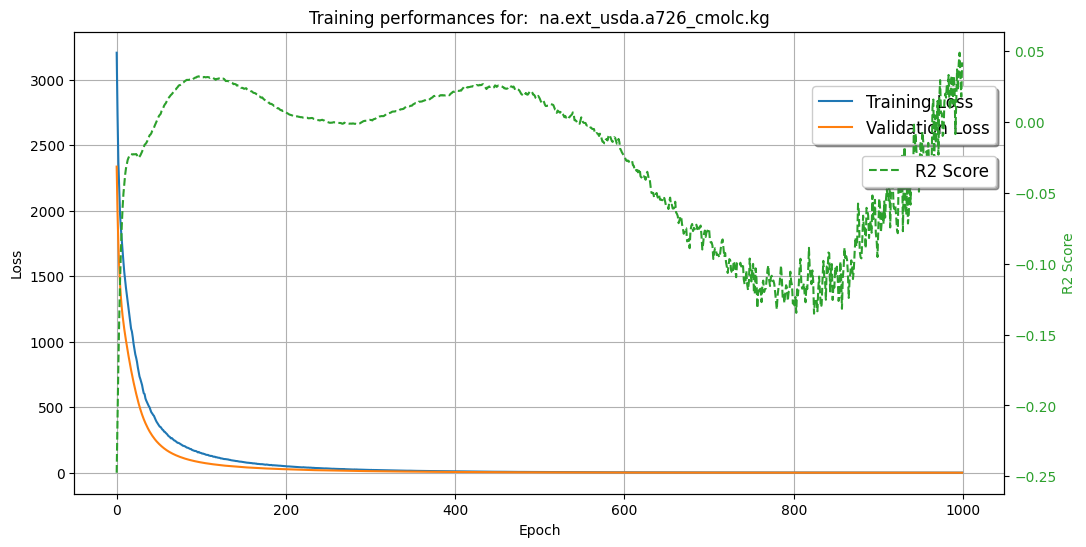

: 

In [8]:
tl = torch.stack(train_losses).numpy()
vl = torch.stack(val_losses).numpy()
r2= np.array(val_r2_scores)

# Plotting Training and Validation Losses
for i,y in enumerate(y_labels):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(tl[:,i], label=f'Training Loss',color='tab:blue')
    ax1.plot(vl[:,i], label=f'Validation Loss',color='tab:orange')
    ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True, fontsize=12)
    
    ax2 = ax1.twinx()
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylabel('R2 Score', color='tab:green')
    ax2.plot(r2[:,i], label=f'R2 Score', linestyle='--',color='tab:green')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.75), fancybox=True, shadow=True, fontsize=12)
   
    ax1.grid(True)
    plt.title(f'Training performances for:  {y}')
    plt.show(block=False)


In [9]:
name_model ="_Vit1D_OSSL_"  
save_path = os.path.dirname(data_path) + f'\\models\\{name_model}\\'+ name_model

model = ViT_1D(mean = mean, std = std, seq_len = spec_dims, patch_size = 50, dim_embed = 64, trans_layers = 8, heads = 8, mlp_dim = 64, out_dims = 2) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')

train_losses, val_losses, val_r2_scores , final_save_path=train(model, optimizer, criterion, train_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,plot_fig=False)


Epoch 1/1000 | Train Losses: y 0: 1.1807, y 1: 0.8742 | Validation Losses: y 0: 0.9776, y 1: 0.8505 | R2 Scores: y 0: -293.8213, y 1: -147.1070
Epoch 2/1000 | Train Losses: y 0: 0.8955, y 1: 0.7755 | Validation Losses: y 0: 0.8353, y 1: 0.7676 | R2 Scores: y 0: -262.0182, y 1: -64.7037
Epoch 3/1000 | Train Losses: y 0: 0.8280, y 1: 0.7158 | Validation Losses: y 0: 0.8160, y 1: 0.7149 | R2 Scores: y 0: -196.1791, y 1: -28.9207
Epoch 4/1000 | Train Losses: y 0: 0.8192, y 1: 0.6706 | Validation Losses: y 0: 0.8111, y 1: 0.6705 | R2 Scores: y 0: -123.5123, y 1: -14.2322
Epoch 5/1000 | Train Losses: y 0: 0.8145, y 1: 0.6295 | Validation Losses: y 0: 0.8079, y 1: 0.6302 | R2 Scores: y 0: -80.0499, y 1: -7.6612
Epoch 6/1000 | Train Losses: y 0: 0.8115, y 1: 0.5932 | Validation Losses: y 0: 0.8057, y 1: 0.5951 | R2 Scores: y 0: -57.7899, y 1: -4.4592
Epoch 7/1000 | Train Losses: y 0: 0.8092, y 1: 0.5626 | Validation Losses: y 0: 0.8035, y 1: 0.5660 | R2 Scores: y 0: -47.5758, y 1: -2.8185
Epoc

In [ ]:
tl = torch.stack(train_losses).numpy()
vl = torch.stack(val_losses).numpy()
r2= np.array(val_r2_scores)

# Plotting Training and Validation Losses
for i,y in enumerate(y_labels):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(tl[:,i], label=f'Training Loss',color='tab:blue')
    ax1.plot(vl[:,i], label=f'Validation Loss',color='tab:orange')
    ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True, fontsize=12)
    
    ax2 = ax1.twinx()
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylabel('R2 Score', color='tab:green')
    ax2.plot(r2[:,i], label=f'R2 Score', linestyle='--',color='tab:green')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.75), fancybox=True, shadow=True, fontsize=12)
   
    ax1.grid(True)
    plt.title(f'Training performances for:  {y}')
    plt.show(block=False)